In [1]:
import tensorflow as tf
import cudf
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow_probability as tfp
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from scipy.stats import zscore

2024-01-11 22:20:28.113312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Function to configure GPU
def configure_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
    # Invalid device or cannot modify virtual devices once initialized.
        pass

# Function to load and preprocess data
def load_and_preprocess_data(filepath, test_size=0.2, random_state=42):
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading data file: {e}")
        return None, None, None, None

    y = df['output_val']
    X = df.drop(['output_val'], axis=1)

    X_original = X.copy()
    y_original = y.copy()
    
    # # normalize the data with max-min normalization
    # X = (X - X.min()) / (X.max() - X.min())
    # y= (y - y.min()) / (y.max() - y.min())
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)
    # print(f"X_train shape: {X_train.shape}")
    # print(f"y_train shape: {y_train.shape}")

    #normalize the data with z-score normalization
    X = zscore(X)
    y = zscore(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")

    return X_train, X_test, y_train, y_test
data_file_path = './data/train_data_histogram_longtime_210000_coursegrained.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_file_path)

X_train shape: (1679200, 2)
y_train shape: (1679200,)


In [5]:
#extract R from X_train
R = X_train['R']

In [6]:
@tf.function
def custom_loss_with_integral_penalty(y_true, y_pred, R, integral_penalty_weight=0.00001):

    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    R = tf.cast(R, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    R = tf.reshape(R, (-1, 1))


    # Use tfp.math.trapz for integration
    integral = tfp.math.trapz(y_pred, x=R, axis=0)
    
    # Integral Penalty
    integral_penalty = tf.abs(1 - integral)

    # Total Loss
    total_loss = mse_loss + integral_penalty_weight * integral_penalty

    return total_loss

In [7]:
# Create the neural network model
def create_model(X_train_R, model_type='default', input_shape=(2,)):
    if model_type == 'default':
        model = keras.Sequential([
            keras.layers.Dense(120, activation='tanh', input_shape=input_shape, kernel_initializer='glorot_normal'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(60, activation='tanh', kernel_initializer='glorot_normal'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(60, activation='tanh', kernel_initializer='glorot_normal'),
            keras.layers.Dense(30, activation='tanh', kernel_initializer='glorot_normal'),
            keras.layers.Dense(1, activation='tanh', kernel_initializer='glorot_normal'),
        ])
    elif model_type == 'alt':
        model = keras.Sequential([
                keras.layers.Dense(120, activation='relu', input_shape=(2,)),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(60, activation='relu'),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(60, activation='relu'),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Dense(1, activation='relu'),
        ])
        pass
    else:
        raise ValueError("Invalid model type specified.")
    
    
    def loss_function(y_true, y_pred):
        customloss = custom_loss_with_integral_penalty(y_true, y_pred, X_train_R)
        return customloss
    
    learning_rate = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=loss_function)
    return model
# Train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=8500, validation_split=0.2):
    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        test_loss = model.evaluate(X_test, y_test)
    except Exception as e:
        print(f"Error during training or evaluation: {e}")
        return None, None
    return history, test_loss

In [8]:
def main(model_type='alt'):

    configure_gpu()
    data_file_path = './data/train_data_histogram_longtime_210000_coursegrained.csv' # FILE PATH
    X_train, X_test, y_train, y_test = load_and_preprocess_data(data_file_path)

    if X_train is None:
        print("Failed to load data. Exiting.")
        return
    
    X_train_R = X_train['R']

    model = create_model(X_train_R, model_type=model_type, input_shape=X_train.shape[1:])

    history, test_loss = train_and_evaluate_model(model, X_train, y_train, X_test, y_test,
                                                  epochs=500,
                                                  batch_size=8500)

    if history is not None:
        print(f"Test Loss: {test_loss}")

    
    print("X_train shape: ", X_train.shape)
    # print("y_train shape: ", y_train.shape)
    # print("X_test shape: ", X_test.shape)
    # print("y_test shape: ", y_test.shape)
    # print("Model Summary: ")
    # print(model.summary())

    return history, test_loss, model, X_test, y_test

In [9]:
history, test_loss, model, X_test, y_test = main(model_type='alt')

X_train shape: (1679200, 2)
y_train shape: (1679200,)
Epoch 1/500
159/159 [==============================] - 2s 4ms/step - loss: 0.8794 - val_loss: 0.7304
Epoch 2/500
159/159 [==============================] - 0s 2ms/step - loss: 0.6642 - val_loss: 0.5813
Epoch 3/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5932 - val_loss: 0.5590
Epoch 4/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5766 - val_loss: 0.5512
Epoch 5/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5669 - val_loss: 0.5461
Epoch 6/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5605 - val_loss: 0.5425
Epoch 7/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5552 - val_loss: 0.5403
Epoch 8/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5511 - val_loss: 0.5382
Epoch 9/500
159/159 [==============================] - 0s 2ms/step - loss: 0.5484 - val_loss: 0.5365
Epoch 10/500
159/159 [===============

KeyboardInterrupt: 

In [11]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

13119/13119 [==============================] - 10s 736us/step - loss: 0.5248
Test loss: 0.5248130559921265
13119/13119 [==============================] - 7s 525us/step


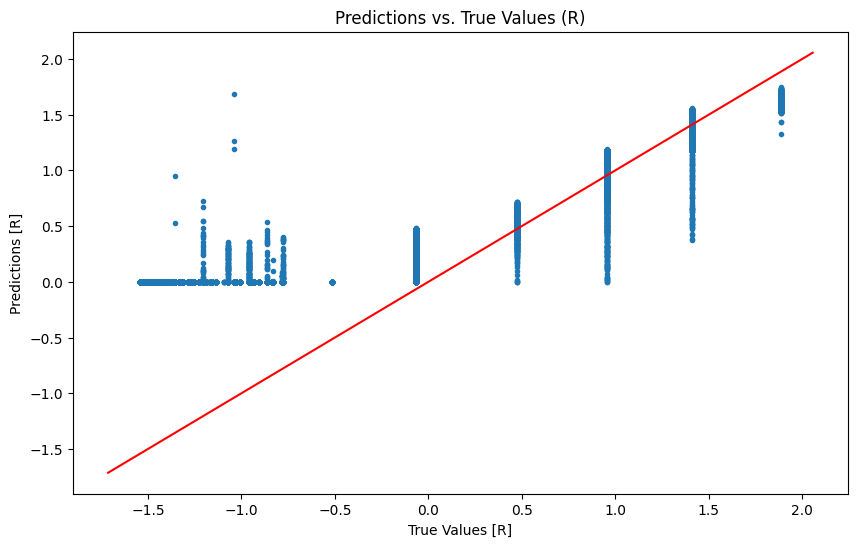

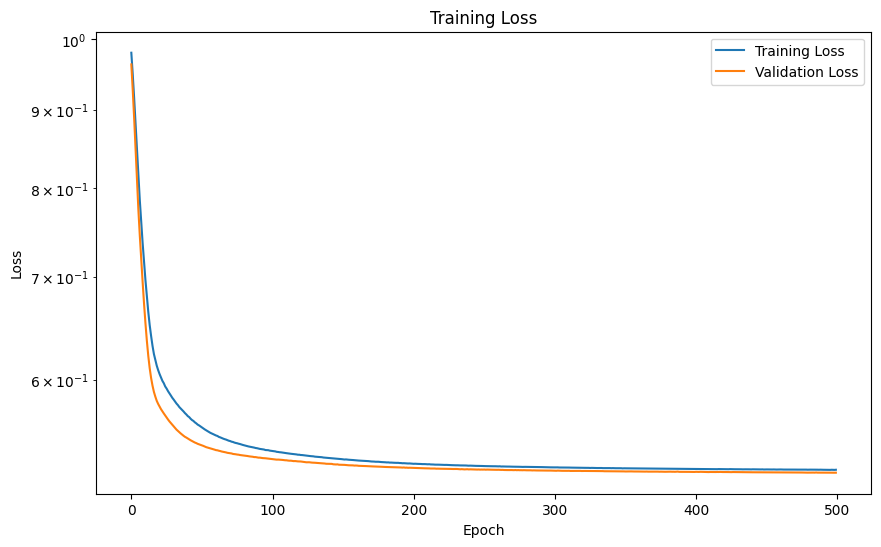

In [12]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [13]:
# extract U and R from the test data
U_test = X_test.iloc[:,0]
R_test = X_test.iloc[:,1]
output_test = y_test.iloc[:]

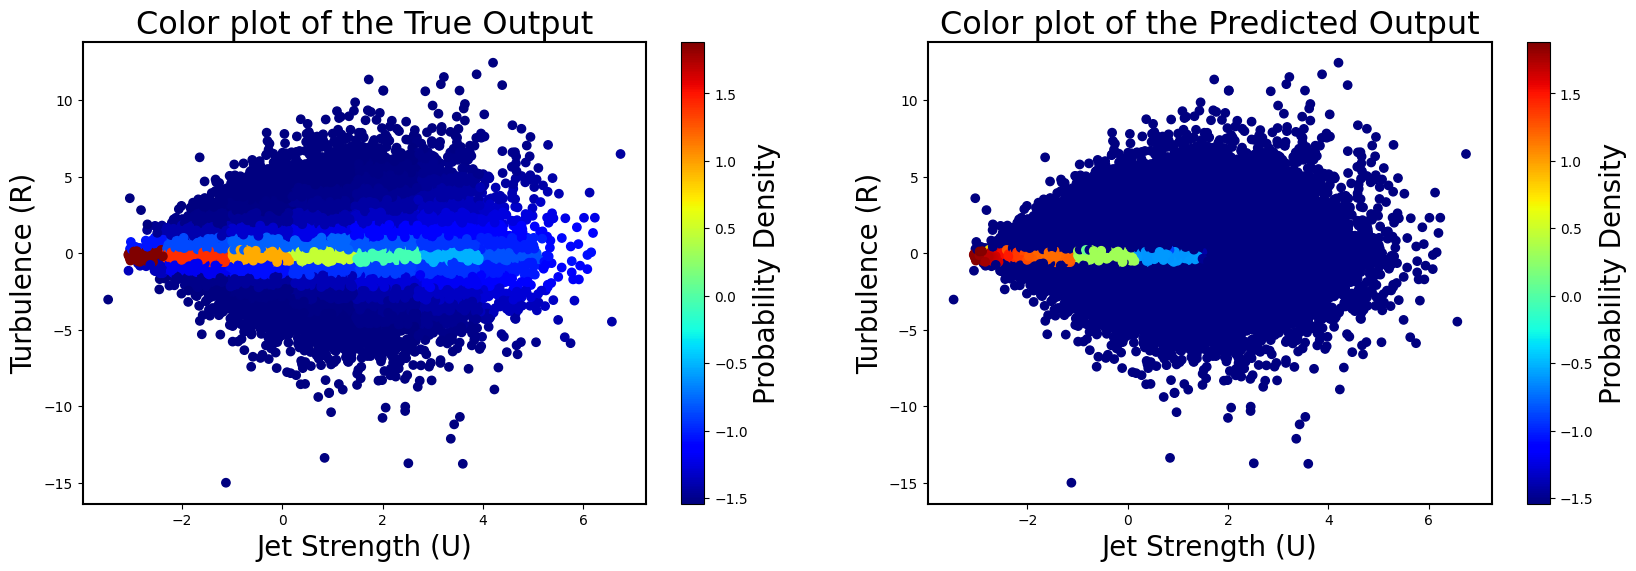

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Your existing code for the scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

scatter1 = ax1.scatter(U_test, R_test, c=output_test, cmap='jet')
ax1.set_xlabel('Jet Strength (U)', fontsize=20)
ax1.set_ylabel('Turbulence (R)', fontsize=20)
ax1.set_title('Color plot of the True Output', fontsize=23)

scatter2 = ax2.scatter(U_test, R_test, c=predictions.reshape(-1), cmap='jet')
ax2.set_xlabel('Jet Strength (U)', fontsize=20)
ax2.set_ylabel('Turbulence (R)', fontsize=20)
ax2.set_title('Color plot of the Predicted Output', fontsize=23)

# Create ScalarMappable objects for the colorbars
norm = colors.Normalize(vmin=min(min(output_test), min(predictions.reshape(-1))), vmax=max(max(output_test), max(predictions.reshape(-1))))
sm = cm.ScalarMappable(cmap='jet', norm=norm)

# Add colorbars
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label('Probability Density', fontsize=20)
cbar2 = fig.colorbar(sm, ax=ax2)
cbar2.set_label('Probability Density', fontsize=20)

# Modify spines to add borders
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

plt.show()


In [23]:
# prove the effetiveness of the prediction by showing the integral of the prediction to be close to 1 with everything in same precision
# convert predictions to float32
predictions = tf.cast(predictions, tf.float32)
R_test = tf.cast(R_test, tf.float32)
output_test = tf.cast(output_test, tf.float32)

integral_pred = tfp.math.trapz(predictions[:,0], x=R_test, axis=0)
integral_true = tfp.math.trapz(output_test, x=R_test, axis=0)

print("Integral of the prediction: ", integral_pred)
print("Integral of the true output: ", integral_true)

Integral of the prediction:  tf.Tensor(12688.325, shape=(), dtype=float32)
Integral of the true output:  tf.Tensor(22757.139, shape=(), dtype=float32)


# Penalty Weight Value Analysis

In [10]:
def custom_loss_with_integral_penalty(y_true, y_pred, R, integral_penalty_weight):
    # Cast all tensors to float32
    y_true = tf.cast(tf.reshape(y_true, (-1, 1)), tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, (-1, 1)), tf.float32)
    R = tf.cast(tf.reshape(R, (-1, 1)), tf.float32)

    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    integral = tfp.math.trapz(y_pred, x=R, axis=0)
    integral_penalty = tf.abs(1 - integral)
    total_loss = mse_loss + integral_penalty_weight * integral_penalty

    return mse_loss.numpy(), integral_penalty.numpy(), total_loss.numpy()

# Simulate predictions from your model
noise_level = 0.1  # Adjust this based on how close you expect y_pred to be to y_train
y_pred = y_train + np.random.normal(0, noise_level, y_train.shape)

# Range of penalty weights to test
penalty_weights = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

# Analyze loss components for different penalty weights
for weight in penalty_weights:
    mse_loss, integral_penalty, total_loss = custom_loss_with_integral_penalty(y_train, y_pred, R, weight)
    print(f"Penalty Weight: {weight}")
    print(f"MSE Loss: {mse_loss}")
    print(f"Integral Loss: {integral_penalty*weight}")
    print(f"Total Loss: {total_loss}\n")


Penalty Weight: 1e-05
MSE Loss: 0.010006117634475231
Integral Loss: [0.9300496]
Total Loss: [0.9400557]

Penalty Weight: 0.0001
MSE Loss: 0.010006117634475231
Integral Loss: [9.300496]
Total Loss: [9.310502]

Penalty Weight: 0.001
MSE Loss: 0.010006117634475231
Integral Loss: [93.00497]
Total Loss: [93.01498]

Penalty Weight: 0.01
MSE Loss: 0.010006117634475231
Integral Loss: [930.04956]
Total Loss: [930.0596]

Penalty Weight: 0.1
MSE Loss: 0.010006117634475231
Integral Loss: [9300.496]
Total Loss: [9300.506]

Penalty Weight: 1
MSE Loss: 0.010006117634475231
Integral Loss: [93004.96]
Total Loss: [93004.97]

Penalty Weight: 10
MSE Loss: 0.010006117634475231
Integral Loss: [930049.6]
Total Loss: [930049.6]

